# License detector pipeline visualization

In [1]:
import importlib

import matplotlib

from notebooks.utils import cd_git_root, show, show_contours

matplotlib.rcParams["savefig.pad_inches"] = 0

cd_git_root()

In [2]:
from datasets.load import load_platesmania

datasets = load_platesmania()
ds = datasets.train

paths = ds.paths
to_filter = {
    # 1: "hard",
    # 11: "hard",
    # 12: "hard",
}
paths = [filename for i, filename in enumerate(paths) if i not in to_filter]
path = paths[0]

import random
path = random.choice(paths)

path = "datasets/03-platesmania/pl_KK-3228C_1.jpg"
# path = "datasets/03-platesmania/pl_GD-1661X_1.jpg"
# path = "datasets/03-platesmania/pl_EPJ-00246_1.jpg"
# path = "datasets/03-platesmania/pl_DDZ-KP82_1.jpg"
# path = "datasets/03-platesmania/pl_E1-SKODA_1.jpg"


print("path:", path)

path: datasets/03-platesmania/pl_KK-3228C_1.jpg


## Image loading

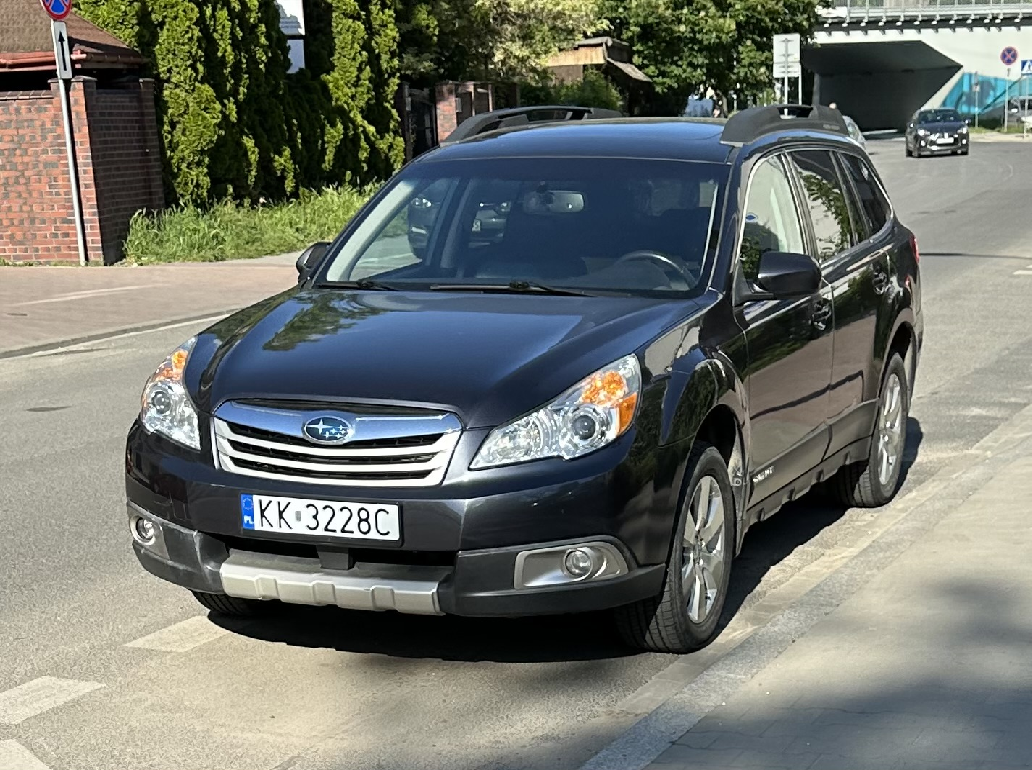

In [3]:
from twm_proj.implementation.image_reader import ImageReader

with open(path, "rb") as file:
    image = ImageReader().read(file)

show(image)

## Initial filtering

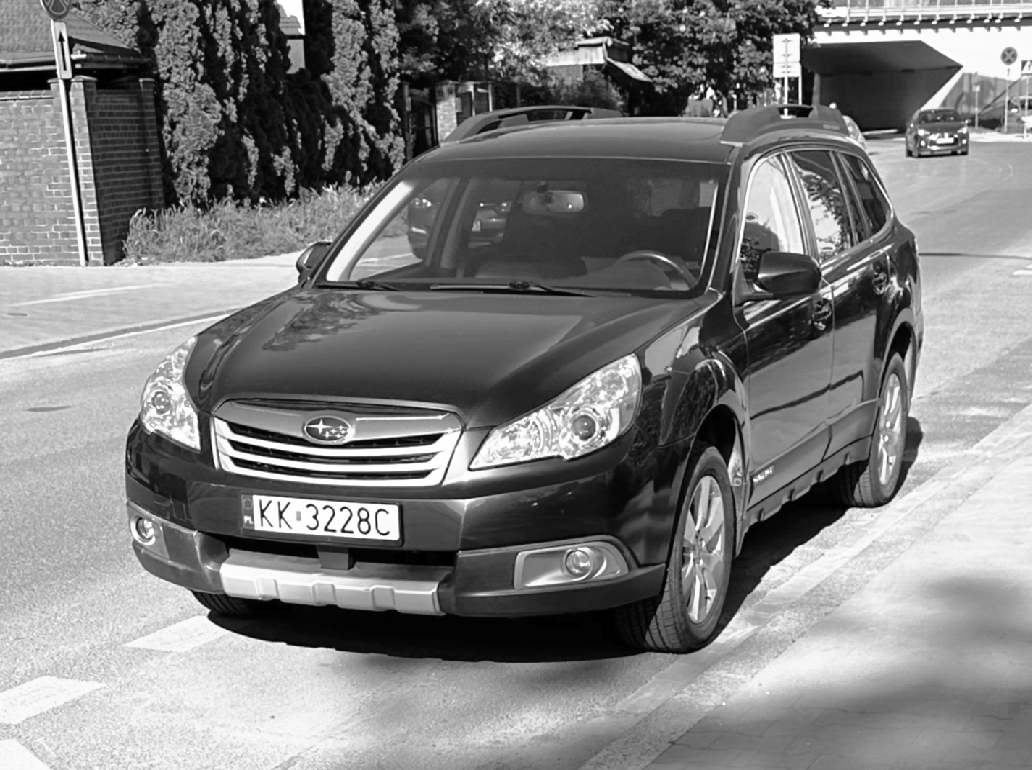

In [4]:
from twm_proj.implementation import initial_filter

importlib.reload(initial_filter)

filtered = initial_filter.InitialFilter().filter(image)
show(filtered)

In [5]:
import cv2
import numpy as np

freq = cv2.dft(filtered.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
freq = 20 * np.log(cv2.magnitude(freq[:, :, 0], freq[:, :, 1]))
height, width = freq.shape[:2]
height, width = height // 2, width // 2
freq = freq[: height, : width]
freq = cv2.normalize(freq, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
xs, ys = np.meshgrid(np.arange(height) / height, np.arange(width) / width)
points = np.vstack([ys.ravel(), xs.ravel()]).T.reshape(width, height, 2).transpose((1, 0, 2))
dists = np.sqrt(np.square(points).sum(axis=2))
# show((dists / dists.max() * 255).astype(np.uint8))
# show(freq)
avg_freq = np.mean([dist * freq for dist, freq in zip(dists.flat, freq.flat)])
print("detail level:", avg_freq)


detail level: 76.74856792405046


## Edge filter

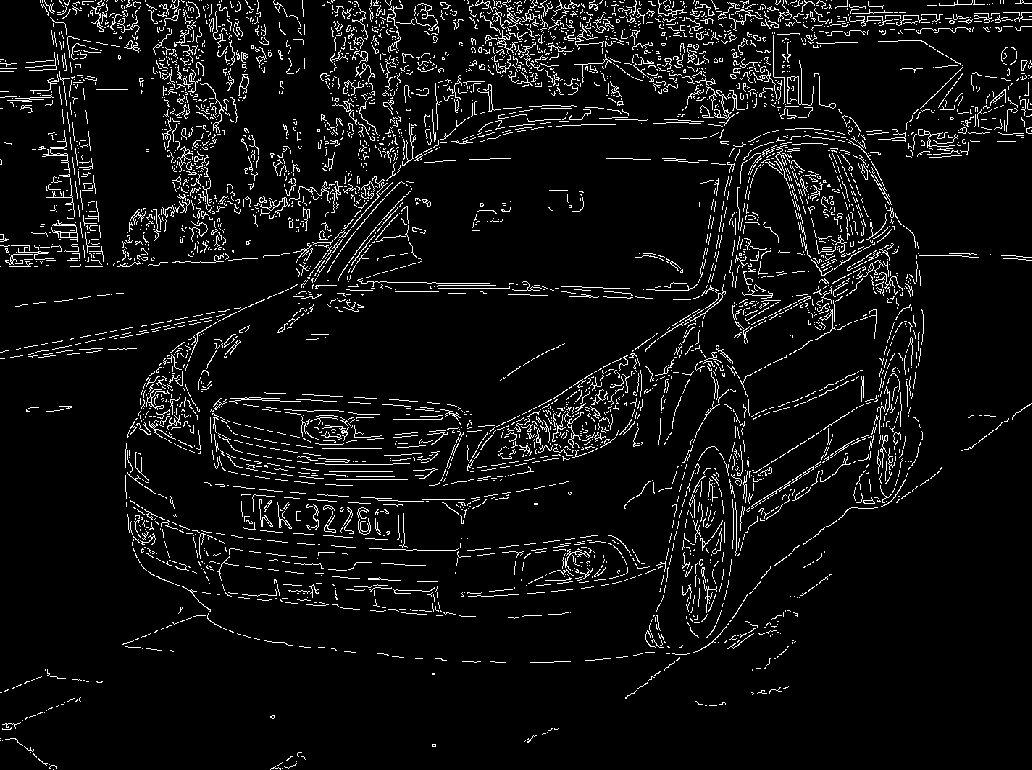

In [6]:
from twm_proj.implementation import edge_filter
importlib.reload(edge_filter)

edges = edge_filter.EdgeFilter().filter(filtered)
show(edges)

## Contour detector

contours count: 125


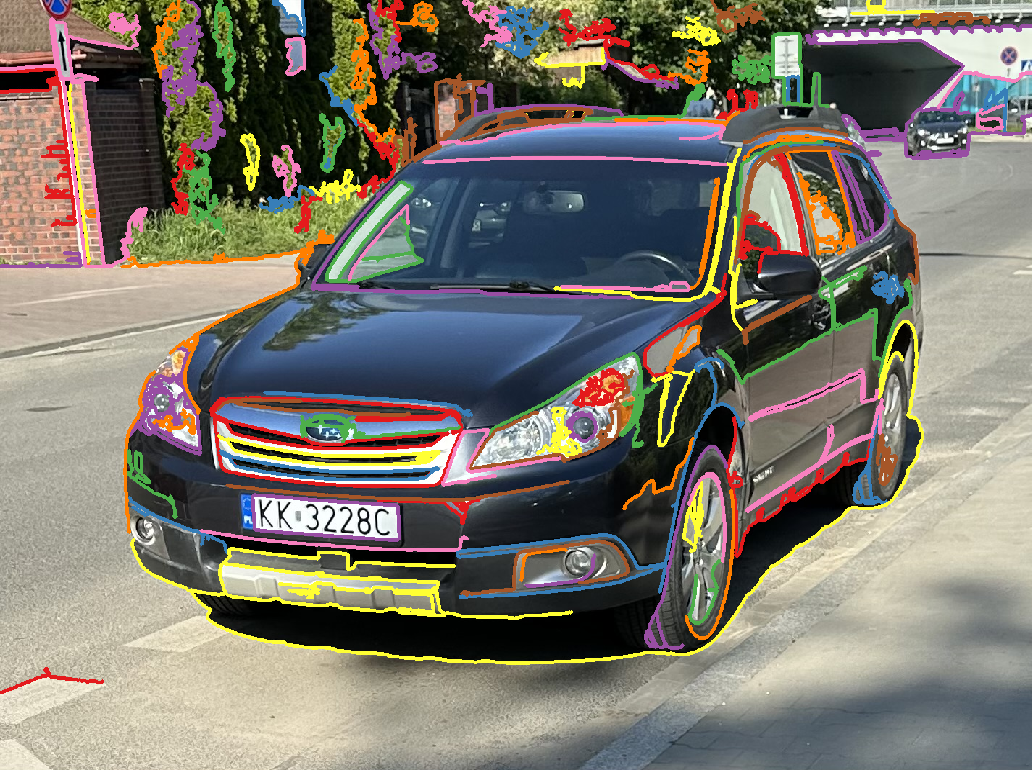

In [7]:
from twm_proj.implementation import contour_detector

from notebooks.utils import filter_by_color

importlib.reload(contour_detector)

contours = [*contour_detector.ContourDetector().detect(edges)]
print("contours count:", len(contours))
filtered_contours = filter_by_color(contours)
show_contours(image, filtered_contours)

## Rectangle detection

rects count: 7
example rect:
 [[348 690]
 [353 736]
 [551 746]
 [545 701]]


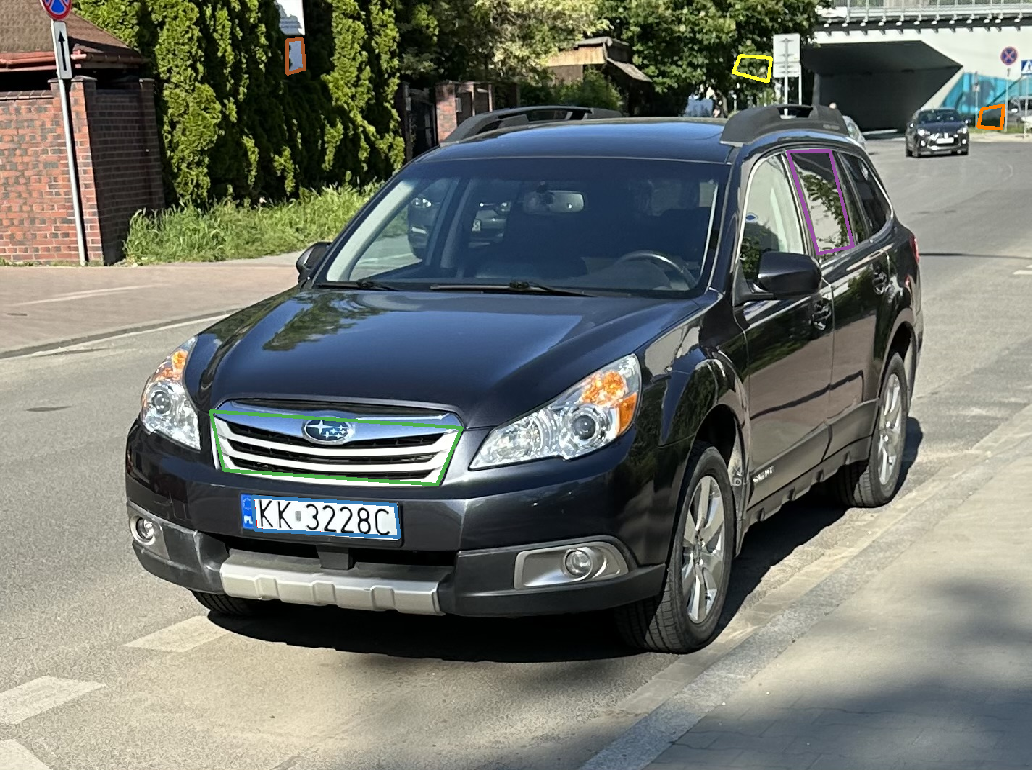

In [8]:
from twm_proj.implementation import rect_detector

importlib.reload(rect_detector)

rects = [rect_detector.RectDetector().detect(contour) for contour in filtered_contours]
rects = [rect for rect in rects if rect is not None]
print("rects count:", len(rects))
print("example rect:\n", rects[0] if rects else None)
show_contours(image, rects)

## Rectangle transforming

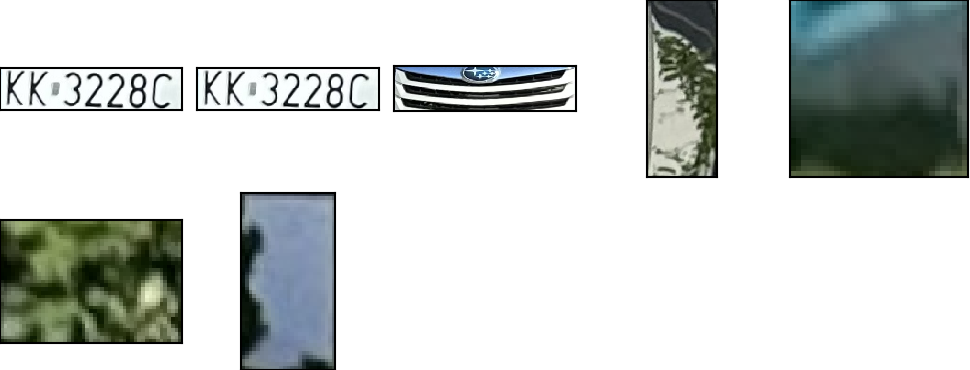

In [9]:
from twm_proj.implementation.rect_transformer import RectTransformer
from notebooks.utils import show_collage

rect_images = [RectTransformer().transform(image, rect) for rect in rects]
show_collage(rect_images, height=2)

## Rectangle classification

In [10]:
from twm_proj.implementation.rect_classifier import RectClassifier
from twm_proj.interface.rect_classifier import RectangleType

rect_classes = [RectClassifier().classify_with_differences(img) for img in rect_images]
display([(rect_class.name, differences) for rect_class, differences in rect_classes])

plates = [
    (rect_img, cls[0], rect)
    for rect_img, cls, rect in zip(rect_images, rect_classes, rects)
    if cls[0] != RectangleType.NOT_PLATE
]

[('ONE_ROW_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.05635451505016731,
   <RectangleType.TWO_ROW_PLATE: 2>: 2.020099786172487,
   <RectangleType.MINI_PLATE: 3>: 0.5577639751552794}),
 ('ONE_ROW_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.05158862876254178,
   <RectangleType.TWO_ROW_PLATE: 2>: 2.035352815395581,
   <RectangleType.MINI_PLATE: 3>: 0.5656314699792961}),
 ('ONE_ROW_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.11542933810375669,
   <RectangleType.TWO_ROW_PLATE: 2>: 1.8310331681280976,
   <RectangleType.MINI_PLATE: 3>: 0.46024363233665566}),
 ('NOT_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.9140852390852391,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.7250332299512627,
   <RectangleType.MINI_PLATE: 3>: 0.8581724581724582}),
 ('NOT_PLATE', {}),
 ('NOT_PLATE', {}),
 ('NOT_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.8833878887070378,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.6267875828392048,
   <RectangleType.MINI_PLATE: 3>: 0.8074974670719351})]

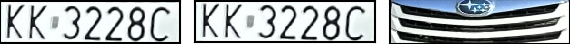

In [11]:
show_collage([plate for plate, _ ,_ in plates], height=2)

## Rectangle de-duplication

In [12]:
display([(cls, rect) for _, cls, rect in plates])

[(<RectangleType.ONE_ROW_PLATE: 1>,
  array([[348, 690],
         [353, 736],
         [551, 746],
         [545, 701]], dtype=int32)),
 (<RectangleType.ONE_ROW_PLATE: 1>,
  array([[348, 690],
         [352, 736],
         [551, 746],
         [545, 701]], dtype=int32)),
 (<RectangleType.ONE_ROW_PLATE: 1>,
  array([[290, 571],
         [309, 653],
         [603, 673],
         [637, 594]], dtype=int32))]

In [13]:
from twm_proj.implementation.rect_deduplicator import RectDeduplicator

rect_deduplicator = RectDeduplicator()

plates_filtered = plates

plates_filtered = [
    plate
    for plate in plates
    if not rect_deduplicator.is_dupe(plate[2])
]

display([(cls, rect) for _, cls, rect in plates_filtered])

[(<RectangleType.ONE_ROW_PLATE: 1>,
  array([[348, 690],
         [353, 736],
         [551, 746],
         [545, 701]], dtype=int32)),
 (<RectangleType.ONE_ROW_PLATE: 1>,
  array([[290, 571],
         [309, 653],
         [603, 673],
         [637, 594]], dtype=int32))]

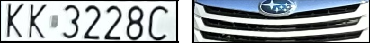

In [14]:
show_collage([p[0] for p in plates_filtered], height=2)

## Pre-OCR processing

RectangleType.ONE_ROW_PLATE
RectangleType.ONE_ROW_PLATE


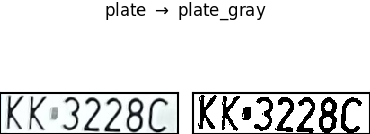

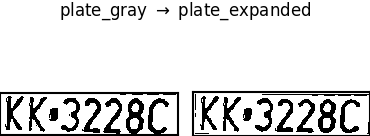

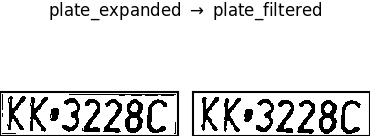

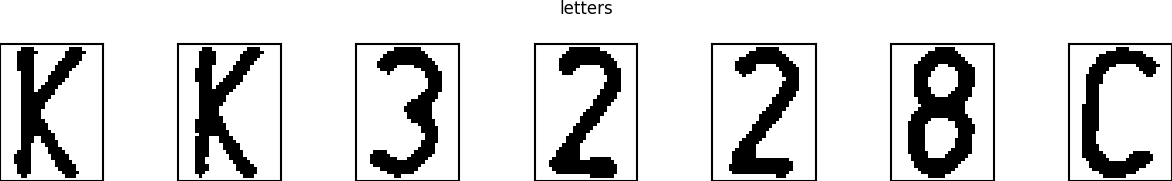

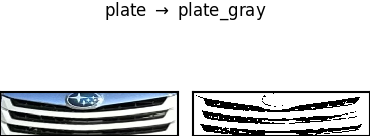

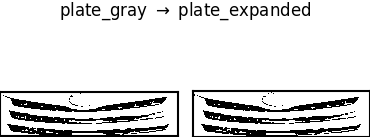

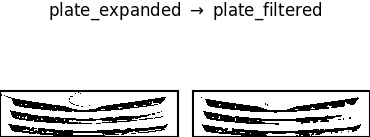

In [15]:
from twm_proj.implementation import pre_ocr

importlib.reload(pre_ocr)

plate_letters = []

for plate, plate_cls, _ in plates_filtered:
    print(plate_cls)
    plate_gray = pre_ocr.PreOcr().to_grayscale(plate)
    plate_expanded = pre_ocr.PreOcr().expand(plate_gray)
    plate_filtered = pre_ocr.PreOcr().filter_grayscale(plate_expanded)
    letters = [*pre_ocr.PreOcr().get_letters(plate_filtered, plate_cls)]
    grid1 = show_collage([plate, plate_gray], col_wrap=2, height=2)
    grid1.fig.set_tight_layout(True)
    grid1.fig.suptitle("plate $\\rightarrow$ plate_gray")
    grid2 = show_collage([plate_gray, plate_expanded], col_wrap=2, height=2)
    grid2.fig.set_tight_layout(True)
    grid2.fig.suptitle("plate_gray $\\rightarrow$ plate_expanded")
    grid3 = show_collage([plate_expanded, plate_filtered], col_wrap=2, height=2)
    grid3.fig.set_tight_layout(True)
    grid3.fig.suptitle("plate_expanded $\\rightarrow$ plate_filtered")
    if len(letters) > 1:
        grid4 = show_collage(letters, col_wrap=len(letters), height=2)
        grid4.fig.set_tight_layout(True)
        grid4.fig.suptitle("letters")

        plate_letters.append(letters)

## OCR

In [16]:
from twm_proj.implementation.ocr import Ocr


for letters in plate_letters:
    scanned_text = Ocr().scan_text(letters)
    print(scanned_text if scanned_text else None)

KK322BC
